
# Yield of DCO mergers per metallicity


Goal of This notebook is to plot the yield of (mostly BBH mergers) as a function of the metallicity


$$ \frac{R_{event}}{d \ln Z} =  \frac{\sum_{z_i}^{z_{i +1}} N_{event} }{ \int_{0}^{i} w_{AIS_i} } \cdot  \frac{10^5}{<M_{pop}> } [M_{\odot}^{-1}], $$ 

here $ N_{event}$ counts the number of events that we have found (like merging BBH) between metallicity $Z_i$ and $Z_{i+1}$,  $<M_{pop}>$ is the average amout of star-forming mass needed to produce this simulation (and we plot per $10^5M_{\odot}$ formed to be consistent with other works , and $w_{AIS_i}$ is the adaptive imporance sampling weight for this bin, normalised over all systems, 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import seaborn as sns

import os
import h5py as h5
from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy import constants as const
from scipy.stats import norm as NormDist

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

import sys
# Import functions
##############################
# This path points to the COMPAS functions in your local folder,
# I've redefined most in this notebook anyway, but I was lazy w.r.t the kroupa IMF etc. 
# sys.path.insert(0,'/n/home04/lvanson/Programs/COMPAS/utils/CosmicIntegration/')
# import ClassCOMPAS as COMPAS_class

import SupportFunctions as sfunc

# import FastCosmicIntegration as COMPAS_sfrd
# from importlib import reload  # Python 3.4+
# reload(COMPAS_sfrd)
##############################


######################################
## locations
save_loc    =  '../plots/'
proj_dir    = '/mnt/home/lvanson/ceph/CompasOutput/' #'/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/'
data_dir    = proj_dir+ '/v02.35.02/N1e5_Fiducial_AllDCO_AIS/'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



## Calculate the average SF mass that would have been required to evolve one binary


In [2]:

def find_star_forming_mass_per_binary_sampling(m1=0.01, m2=0.08, m3=0.5, m4=200.0, a12=0.3, a23=1.3, a34=2.3,
                                               primary_mass_inverse_CDF=None, mass_ratio_inverse_CDF=None, SAMPLES=20000000, 
                                               binaryFraction = 0.7, Mlower = 10.* u.Msun, Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun):
    """
        Calculate the star forming mass evolved for each binary in the file.
        This function does this by sampling from the IMF and mass ratio distributions

        Args:
            mi                       --> [float]    masses at which to transition the slope of the IMF (ignored if primary_mass_inverse_CDF is not None)
            aij                      --> [float]    slope of the IMF between mi and mj (ignored if primary_mass_inverse_CDF is not None)
            primary_mass_inverse_CDF --> [function] a function that computes the inverse CDF functoin for the primary mass distribution
                                                    this defaults to the Kroupa IMF (which can be varied using mi, aij)
            mass_ratio_inverse_CDF   --> [function] a function that computes the inverse CDF function for the mass ratio distribution
                                                    this defaults to assuming a uniform mass ratio on [0, 1]
            SAMPLES                  --> [int]      number of samples to draw when creating a mock universe
            binaryFraction           --> [int]      Asusmed binary fraction, default = 0.7
            Mlower                   --> [int]      Minimum primary mass sampled by COMPAS default = 10 
            Mupper                   --> [int]      Maximum primary mass sampled by COMPAS default = 150
            m2_min                  --> [int]      Minimum secondary mass sampled by COMPAS default = 0.1
    """
    # if primary mass inverse CDF is None, assume the Kroupa IMF
    if primary_mass_inverse_CDF is None:
        primary_mass_inverse_CDF = lambda U: sfunc.inverse_CDF_IMF(U, m1=m1, m2=m2, m3=m3, m4=m4, a12=a12, a23=a23, a34=a34)

    # if mass ratio inverse CDF function is None, assume uniform
    if mass_ratio_inverse_CDF is None:
        mass_ratio_inverse_CDF = lambda q: q

    # randomly sample a large number of masses from IMF, mass ratios from supplied function, binary for boolean
    primary_mass = primary_mass_inverse_CDF(np.random.rand(SAMPLES)) * u.Msun
    mass_ratio = mass_ratio_inverse_CDF(np.random.rand(SAMPLES))
    binary = np.random.rand(SAMPLES)

    # only fbin fraction of stars have a secondary (in a binary)
    binary_mask = binary < binaryFraction

    # assign each a random secondary mass, default 0 because single stars have m2=0 (surprisingly :P)
    secondary_mass = np.zeros(SAMPLES) * u.Msun
    secondary_mass[binary_mask] = primary_mass[binary_mask] * mass_ratio[binary_mask]

    # find the total mass of the whole population
    total_mass = np.sum(primary_mass) + np.sum(secondary_mass)

    # apply the COMPAS cuts on primary and secondary mass
    primary_mask = np.logical_and(primary_mass >= Mlower, primary_mass <= Mupper)
    secondary_mask = secondary_mass > m2_min
    full_mask = np.logical_and(primary_mask, secondary_mask)

    # find the total mass with COMPAS cuts
    total_mass_COMPAS = np.sum(primary_mass[full_mask]) + np.sum(secondary_mass[full_mask])

    # use the totals to find the ratio and return the average mass as well
    f_mass_sampled = total_mass_COMPAS / total_mass
    average_mass_COMPAS = total_mass_COMPAS / len(primary_mass[full_mask])

    # find the average star forming mass evolved per binary in the Universe
    mass_evolved_per_binary = average_mass_COMPAS / f_mass_sampled
    
    return mass_evolved_per_binary


# mass_evolved_per_binary = find_star_forming_mass_per_binary_sampling()
# print('mass_evolved_per_binary', mass_evolved_per_binary)

# n_systems = len(SYS['SEED'])
# Average_SF_mass_needed = (mass_evolved_per_binary * n_systems)
# print('Average_SF_mass_needed', Average_SF_mass_needed)



# Get the number of certain event per metallicity bin

We want to count the number of events (i.e. unstable mass transfer, stellar merger, CE ejection) per metallicity bin


In [3]:

def get_numbers(data_dir = proj_dir + '/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', simname = 'faccTHERMALzetaHG6.0RemMassFRYER2012SNDELAYED', 
                keys_of_interest = ['merging_BBH', 'merging_NSBH', 'merging_NSNS', 'Stellar_mergers', 'CE_Event_Counter', 'EjectedCE'], verbose = False):

    ################################################
    # Count the number of events 
    ################################################
    # Read data and put in astropy table
    File        = h5.File(data_dir + simname +'/COMPAS_Output_wWeights.h5' ,'r')
    if verbose: print(File['BSE_Double_Compact_Objects'].keys())

    # Add relevant SYS keys to SYS_num table
    SYS_nums = Table()
    print('!!!!!!!!!!!!', File['BSE_Common_Envelopes'].keys() )
    for key in ['SEED', 'CE_Event_Counter', 'mixture_weight', 'Metallicity@ZAMS(1)',  'Merger', 'Optimistic_CE', 'Immediate_RLOF>CE']:
        SYS_nums[key] = File['BSE_System_Parameters'][key][()]
        
    # General numbers for this simulation
    n_systems = len(SYS_nums['SEED'])
    M1_min    = min(File['BSE_System_Parameters']['Mass@ZAMS(1)'][()]) #minimum ZAMS mass simulated

    #Bool to point SYS to DCO
    SYS_DCO_seeds_bool           = np.in1d(File['BSE_System_Parameters']['SEED'][()], File['BSE_Double_Compact_Objects']['SEED'][()])

    # Add relevant DCO keys to SYS_num table
    for dcokey in ['Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time']:
        SYS_nums[dcokey]  = np.zeros(len(SYS_nums))
        # Thoses systems that become DCO
        SYS_nums[dcokey][SYS_DCO_seeds_bool] = File['BSE_Double_Compact_Objects'][dcokey][()]

    File.close()

    ################################################
    # Create a new table events per metallicity bin
    ################################################
    events_per_Zbin = Table()
    
    ################################################
    # Create metallicity bins
    ################################################
    Metal_bins  = np.linspace(-4, max(np.log10(SYS_nums['Metallicity@ZAMS(1)'])), 15)
    center_bins = (Metal_bins[1:] + Metal_bins[:-1])/2.    
    binwidts    = np.diff(Metal_bins)
    events_per_Zbin['Metallicity_bin'] = center_bins
    events_per_Zbin['dlnZ']            = binwidts
    
    # Digitize your systems per metallicity
    SYSbin_indices = np.digitize(np.log10(SYS_nums['Metallicity@ZAMS(1)']) , Metal_bins, right=True)  
    
    # AIS fraction per metal bin normalized
    events_per_Zbin['mixture_weight_sum']  = np.bincount(SYSbin_indices, weights=SYS_nums['mixture_weight'])[1:]/sum(SYS_nums['mixture_weight'])
    
    ###########
    # Number of BBH mergers
    if 'merging_BBH' in keys_of_interest:
        BBH_bool      = np.logical_and(SYS_nums['Stellar_Type(1)'] == 14,SYS_nums['Stellar_Type(2)'] == 14 )
        NO_RLOF_CE    = SYS_nums['Immediate_RLOF>CE'] == False
        pessimisticCE = SYS_nums['Optimistic_CE'] == False
        merger        = SYS_nums['Merges_Hubble_Time'] == True
        stable        = SYS_nums['CE_Event_Counter'] == 0
        #
        SYS_nums['merging_BBH']                 = BBH_bool * NO_RLOF_CE * pessimisticCE * merger
        events_per_Zbin['merging_BBH']          = np.bincount(SYSbin_indices, weights=SYS_nums['merging_BBH']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]
        
        # Split by stable only or CE channel
        SYS_nums['merging_BBH_stable']          = BBH_bool * NO_RLOF_CE * pessimisticCE * merger * stable
        events_per_Zbin['merging_BBH_stable']   = np.bincount(SYSbin_indices, weights=SYS_nums['merging_BBH_stable']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]
        
        SYS_nums['merging_BBH_CE']              = BBH_bool * NO_RLOF_CE * pessimisticCE * merger  *np.invert(stable)
        events_per_Zbin['merging_BBH_CE']       = np.bincount(SYSbin_indices, weights=SYS_nums['merging_BBH_CE']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]
        

    ###########
    # Number of BHNS mergers
    if 'merging_NSBH' in keys_of_interest:
        NSBH_bool     = np.logical_or(np.logical_and(SYS_nums['Stellar_Type(1)'] == 13,SYS_nums['Stellar_Type(2)'] == 14 ),
                                      np.logical_and(SYS_nums['Stellar_Type(1)'] == 14,SYS_nums['Stellar_Type(2)'] == 13 ))
        SYS_nums['merging_NSBH']          = NSBH_bool * NO_RLOF_CE * pessimisticCE * merger
        events_per_Zbin['merging_NSBH']   = np.bincount(SYSbin_indices, weights=SYS_nums['merging_NSBH']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]
        
    ###########
    # Number of NSNS mergers
    if 'merging_NSNS' in keys_of_interest:
        NSNS_bool     = np.logical_and(SYS_nums['Stellar_Type(1)'] == 13,SYS_nums['Stellar_Type(2)'] == 13 )
        SYS_nums['merging_NSNS']         = NSNS_bool * NO_RLOF_CE * pessimisticCE * merger
        events_per_Zbin['merging_NSNS']  = np.bincount(SYSbin_indices, weights=SYS_nums['merging_NSNS']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]
        
        
    ###########
    # Number of CE that occurred in all systems
    if 'CE_Event_Counter' in keys_of_interest:
        events_per_Zbin['CE_Event_Counter']    = np.bincount(SYSbin_indices, weights=SYS_nums['CE_Event_Counter']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]
    
    ###########
    # Number of stellar mergers
    if 'Stellar_mergers' in keys_of_interest:
        # Wherever either of these is true, the CE should be counted as a stellar merger
        SYS_nums['Merger'][SYS_nums['Optimistic_CE'] == True ] = 1
        SYS_nums['Merger'][SYS_nums['Immediate_RLOF>CE'] == True ] = 1

        # OK weirdly, there are stellar mergers that happen when no CE has happened, 
        # For now I am going to disregard those mergers (not count them)
        merged_wo_CE = np.where(SYS_nums['Merger'] >  SYS_nums['CE_Event_Counter'])[0]
        SYS_nums['Merger'][merged_wo_CE ] = 0
        events_per_Zbin['Stellar_mergers']     = np.bincount(SYSbin_indices, weights=SYS_nums['Merger']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]

    ###########
    # Number of Succesfull ejections is all CE - stellar mergers
    if 'EjectedCE' in keys_of_interest:
        SYS_nums['EjectedCE']        = SYS_nums['CE_Event_Counter'] - SYS_nums['Merger']
        events_per_Zbin['EjectedCE'] = np.bincount(SYSbin_indices, weights=SYS_nums['EjectedCE']*SYS_nums['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]

    ################################################
    # Compute average stellar mass needed to reproduce this simulation
    ################################################
    mass_evolved_per_binary = find_star_forming_mass_per_binary_sampling(binaryFraction = 0.7, Mlower = M1_min* u.Msun, Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun)

    Average_SF_mass_needed = (mass_evolved_per_binary * n_systems)
    if verbose: print('Average_SF_mass_needed', Average_SF_mass_needed)
        
    events_per_Zbin['Average_SF_mass_needed'] = Average_SF_mass_needed

        
    return events_per_Zbin
    


# As a yield per 10^5 Msun 


$$ \frac{R_{event}}{d \ln Z} =  \frac{\sum_{z_i}^{z_{i +1}} N_{event} }{ \int_{0}^{i} w_{AIS_i} } \cdot  \frac{10^5}{<M_{pop}> } $$


$w_{AIS_i}$ is the adaptive imporance sampling weight for this bin, normalised over all systems, 

### Collecting data from simulation


In [12]:
# ## get the data for this simualtion
N1e5_Fiducial_AllDCO_AIS = get_numbers(data_dir = proj_dir+ '/v02.35.02/N1e5_Fiducial_AllDCO_AIS/', simname = 'MainRun')
N1e6_Fiducial_AllDCO_AIS = get_numbers(data_dir = proj_dir+ '/v02.35.02/N1e6_Fiducial_AllDCO_AIS/', simname = 'MainRun')
N1e7_Fiducial_AllDCO_AIS = get_numbers(data_dir = proj_dir+ '/v02.35.02/N1e7_Fiducial_AllDCO_AIS/', simname = 'MainRun')


# ## Variations on AIS
N1e6_Fiducial_BHBH_AIS = get_numbers(data_dir = proj_dir+ '/v02.35.02/N1e6_Fiducial_BHBH_AIS/', simname = 'MainRun')
N1e6_Fiducial_NSNS_AIS = get_numbers(data_dir = proj_dir+ '/v02.35.02/N1e6_Fiducial_NSNS_AIS/', simname = 'MainRun')


!!!!!!!!!!!! <KeysViewHDF5 ['BE_Fixed(1)', 'BE_Fixed(2)', 'BE_Kruckow(1)', 'BE_Kruckow(2)', 'BE_Loveridge(1)', 'BE_Loveridge(2)', 'BE_Loveridge_Winds(1)', 'BE_Loveridge_Winds(2)', 'BE_Nanjing(1)', 'BE_Nanjing(2)', 'Binding_Energy<CE(1)', 'Binding_Energy<CE(2)', 'CE_Event_Counter', 'Double_Core_CE', 'Eccentricity<CE', 'Eccentricity>CE', 'Immediate_RLOF>CE', 'Lambda@CE(1)', 'Lambda@CE(2)', 'Lambda_Fixed(1)', 'Lambda_Fixed(2)', 'Lambda_Kruckow(1)', 'Lambda_Kruckow(2)', 'Lambda_Loveridge(1)', 'Lambda_Loveridge(2)', 'Lambda_Loveridge_Winds(1)', 'Lambda_Loveridge_Winds(2)', 'Lambda_Nanjing(1)', 'Lambda_Nanjing(2)', 'Luminosity<CE(1)', 'Luminosity<CE(2)', 'MT_History', 'Mass(1)<CE', 'Mass(1)>CE', 'Mass(2)<CE', 'Mass(2)>CE', 'Mass_Env(1)', 'Mass_Env(2)', 'Merger', 'Optimistic_CE', 'RLOF(1)', 'RLOF(2)', 'Radius(1)<CE', 'Radius(1)>CE', 'Radius(2)<CE', 'Radius(2)>CE', 'Record_Type', 'RocheLobe(1)<CE', 'RocheLobe(1)>CE', 'RocheLobe(2)<CE', 'RocheLobe(2)>CE', 'SEED', 'SemiMajorAxis<CE', 'SemiMajorA

# Plot all with analytical estimate

# As a yield per Msun 


$$ \frac{R_{event}}{d \ln Z} =  \frac{\sum_{z_i}^{z_{i +1}} N_{event} }{ \int_{0}^{i} w_{AIS_i} } \cdot  \frac{1}{<M_{pop}> } $$


$w_{AIS_i}$ is the adaptive imporance sampling weight for this bin, normalised over all systems, 


/tmp/ipykernel_2188856/876835522.py:35: RuntimeWarning: invalid value encountered in log
  F = y * np.log(w - logZ)


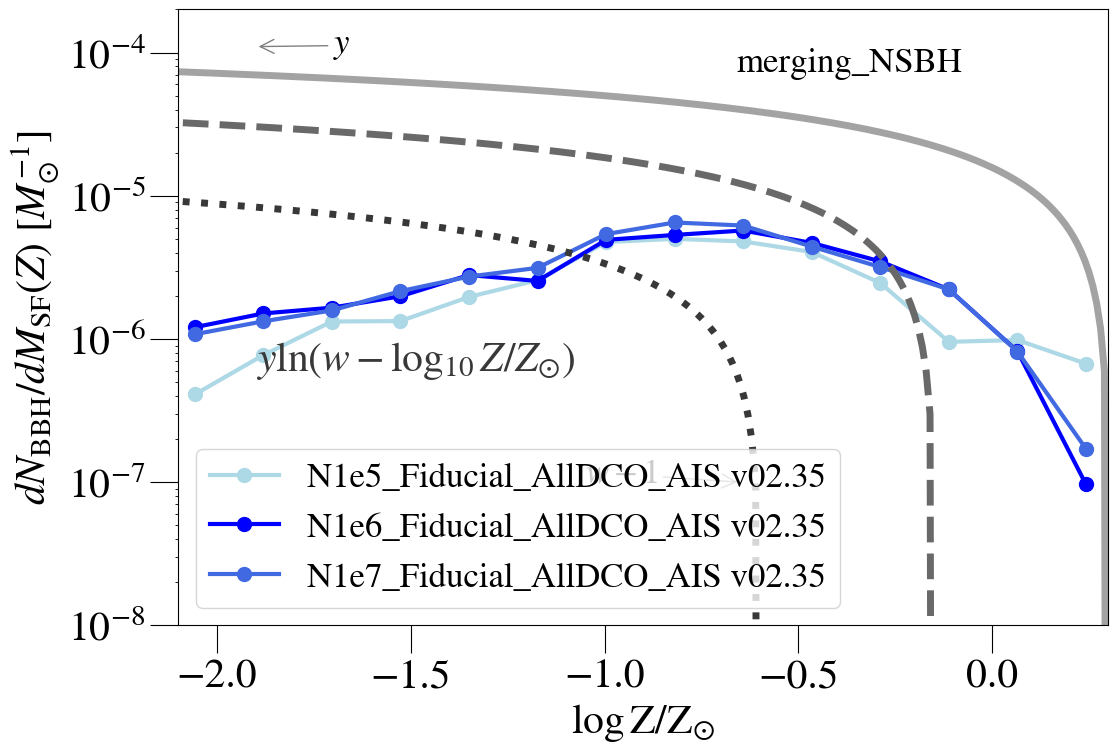

In [24]:

# ['merging_BBH', 'merging_NSBH', 'merging_NSNS', 'Stellar_mergers', 'CE_Event_Counter', 'EjectedCE']
from tqdm import trange


KEY = 'merging_NSBH' # 'merging_BBH' #'merging_NSNS'# 

Zsun = 0.014 
variations           = [N1e5_Fiducial_AllDCO_AIS, N1e6_Fiducial_AllDCO_AIS, N1e7_Fiducial_AllDCO_AIS]#[N1e6_Fiducial_NSNS_AIS, N1e6_Fiducial_BHBH_AIS,N1e6_Fiducial_AllDCO_AIS]#
variation_colors     = ['lightblue', 'blue', 'royalblue']#['#77c99c', '#12b059', '#005909'] #
variation_labels     = ['N1e5_Fiducial_AllDCO_AIS v02.35', 'N1e6_Fiducial_AllDCO_AIS v02.35', 'N1e7_Fiducial_AllDCO_AIS v02.35']#['N1e6_Fiducial_NSNS_AIS','N1e6_Fiducial_BHBH_AIS', 'N1e6_Fiducial_AllDCO_AIS']
#zeta_labels, beta_labels, fcore_labels, fcircum_labels, Fryer22_labels, THERMAL_labels]

####################
fig, ax = plt.subplots(figsize = (12,8))

# loop over all simulations in this variation
for i, events_per_Zbin  in enumerate(variations):

    yield_event = events_per_Zbin[KEY] /events_per_Zbin['Average_SF_mass_needed']  * (1./events_per_Zbin['mixture_weight_sum']) 

    ax.plot(np.log10((10**events_per_Zbin['Metallicity_bin'])/Zsun), yield_event,
                marker = 'o', markersize = 10, lw = 3, alpha = 1, c = variation_colors[i], label = variation_labels[i],  zorder = 1)


#####################
# Analytical estimates
logZ = np.arange(-3, 0.5, step = 0.01)
# log_colors = ['#680003','#BC0000','#F5704A'] #Red
log_colors = ['#383838','#696969','#a3a3a3'] #orange
#     log_colors = ['#004581','#018abd','#97cbdc'] #blue
linestyles = [':', '--', '-']
y_vals = [1e-5, 3e-5, 6e-5]
w_vals = [0.4, 0.85, 1.3]
for i, (y, w) in enumerate(zip(y_vals, w_vals)):
    F = y * np.log(w - logZ)
    plt.plot(logZ, F, lw = 5, color = log_colors[i], ls = linestyles[i])
    
#     plt.text(-0.7, 8e-5,'$y \ln (w-\log_{10} Z/Z_{\odot})$', size =30, color = '#680003')
plt.text(-1.9, 6e-7,'$y \ln (w-\log_{10} Z/Z_{\odot})$', size =30, color = log_colors[0])
ax.annotate('$y$', xytext=(-1.7, 1e-4), xy=(-1.9, 1.1*1e-4),  arrowprops={"arrowstyle":"->", "color":"gray"})
ax.annotate('$w-1$', xytext=(-1.05, 1e-7), xy=(-0.65, 1e-7),  arrowprops={"arrowstyle":"->", "color":"gray"})

########
ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

ax.text(0.6, 0.9, KEY, transform=ax.transAxes, fontsize=25)

plt.xlabel('$\mathrm{\log Z/Z_{\odot}}$', fontsize = 30)
plt.ylabel('$dN_{\mathrm{BBH} }/dM_{\mathrm{SF}}(Z)$ $[M^{-1}_{\odot}]$', fontsize = 30)

plt.xlim(-2.1, 0.3)
plt.ylim(1e-8, 2*1e-4)
plt.yscale('log')
plt.legend()
plt.savefig(save_loc + '/'+KEY+'Yield_resolution_test.pdf', bbox_inches='tight')
plt.show()

    

# Plot all with one highlighted each time

0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


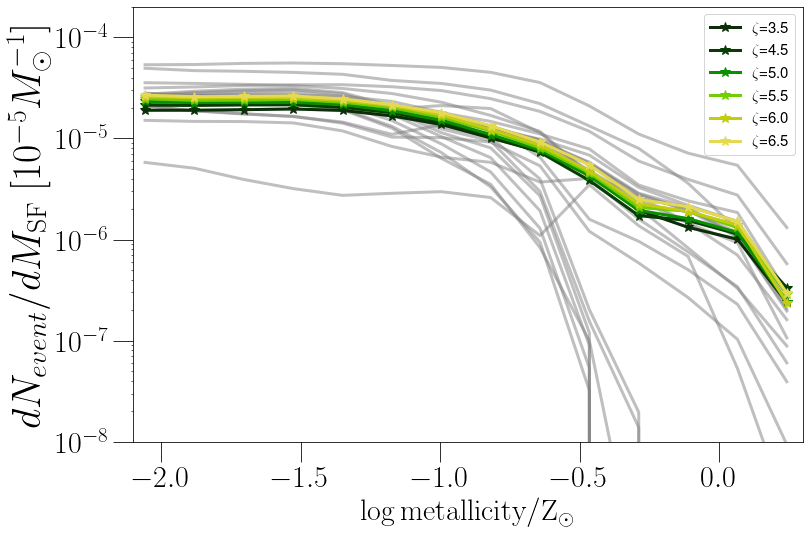

1


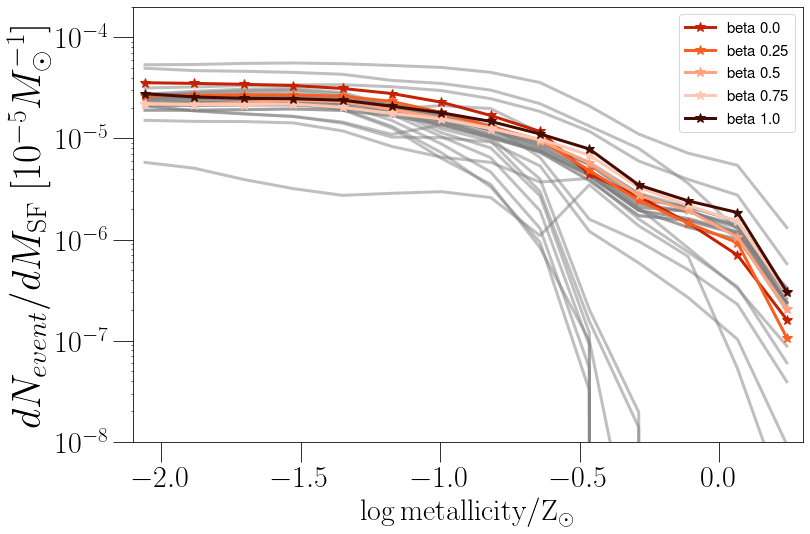

2


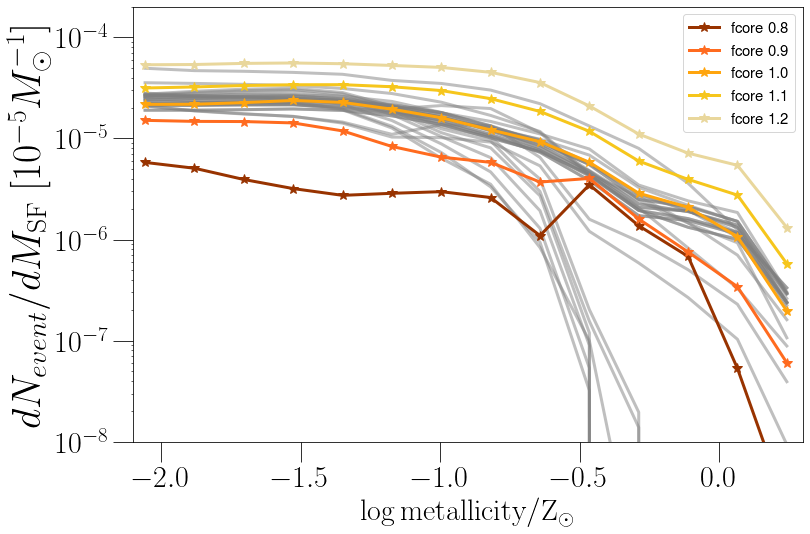

3


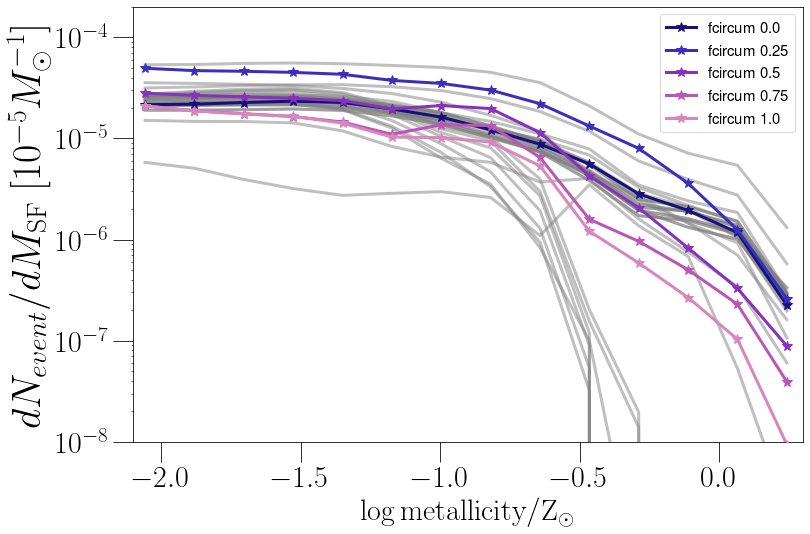

4


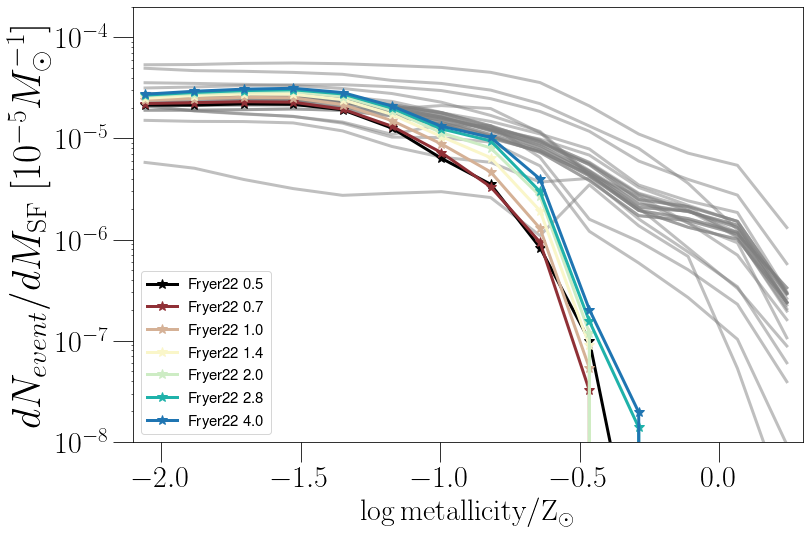

5


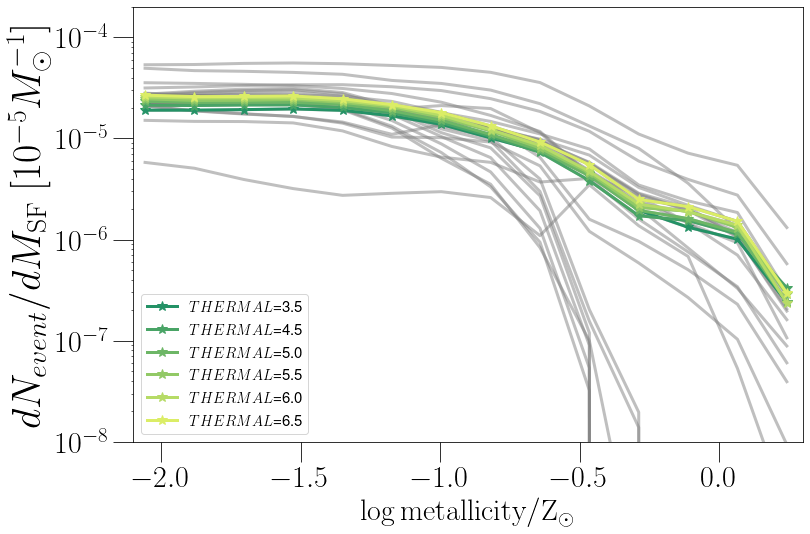

In [ ]:

# ['merging_BBH', 'merging_NSBH', 'merging_NSNS', 'Stellar_mergers', 'CE_Event_Counter', 'EjectedCE']
KEY = 'merging_BBH'

Zsun = 0.014 
variations           = [zeta_tables, beta_tables, fcore_tables, fcircum_tables, Fryer22_tables, THERMAL_tables]
variation_colors     = [zeta_colors, beta_colors, fcore_colors, fcircum_colors, Fryer22_colors, THERMAL_colors]
variation_labels     = [zeta_labels, beta_labels, fcore_labels, fcircum_labels, Fryer22_labels, THERMAL_labels]
names                = ['zeta', 'beta', 'fcore', 'fcircum', 'Fryer22', 'THERMAL']

for highlight in range(len(variations)) :
    print(highlight)
    ####################
    fig, ax = plt.subplots(figsize = (12,8))

    # For every list of variations
    for v, variation_table_list in enumerate(variations):
        
        if v == highlight:
            # Pick the list of labels and colors that belong to this variation
            colors = variation_colors[v][0]
            labels = variation_labels[v]
            Zorder, alph, mark = 100, 1, '*'
        else:
            colors = np.full(len(variation_table_list),'grey')
            labels = np.full(len(variation_table_list),None)
            Zorder, alph, mark = 1, 0.5, ''


        # loop over all simulations in this variation
        for i, events_per_Zbin  in enumerate(variation_table_list):

            yield_event = events_per_Zbin[KEY] /events_per_Zbin['Average_SF_mass_needed']  * (1./events_per_Zbin['mixture_weight_sum']) 

            ax.plot(np.log10((10**events_per_Zbin['Metallicity_bin'])/Zsun), yield_event,
                     marker = mark, markersize = 10, lw = 3, alpha = alph, c = colors[i], label = labels[i],  zorder = Zorder)

    
    ########
    ax.tick_params(axis='both', which='major', labelsize=20, size=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.locator_params(axis='y', nbins=6)

    plt.xlabel('$\mathrm{\log metallicity/Z_{\odot}}$', fontsize = 30)
    plt.ylabel('$dN_{event}/dM_{\mathrm{SF} }$ $[10^{-5} M^{-1}_{\odot}]$', fontsize = 40)

    plt.xlim(-2.1, 0.3)
    plt.ylim(1e-8, 2*1e-4)
    plt.yscale('log')
    plt.legend(fontsize = 15)
    plt.savefig(save_loc + '/'+KEY+'Yield_'+names[highlight]+'.pdf')
    plt.show()

    

# Finding an analytical function for the yield

In [ ]:
####################
fig, ax = plt.subplots(figsize = (12,8))

x = np.linspace(-3, 1)

plt.plot(x, 1e-5 * np.log(5-x))

########
ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.xlabel('$\mathrm{\log metallicity/Z_{\odot}}$', fontsize = 30)
plt.ylabel('$dN_{event}/dM_{\mathrm{SF} }$ $[10^{-5} M^{-1}_{\odot}]$', fontsize = 40)

plt.ylim(1e-8, 2*1e-4)
plt.yscale('log')
plt.legend(fontsize = 15)
# plt.savefig(save_loc + '/BBHYield_CEVariations'+names[highlight]+'.pdf')
plt.show()

    

In [ ]:
## First get the data for one simualtion
events_per_Zbin, n_systems, Average_SF_mass_needed = get_numbers(data_dir = proj_dir + '/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', simname = 'faccTHERMALzetaHG6.0RemMassFRYER2012SNDELAYED', keys_of_interest = ['merging_BBH'])
# display(events_per_Zbin)


ValueError: too many values to unpack (expected 3)

In [ ]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,8))

Zsun = 0.014 

colors   = sns.color_palette("rocket", 5 )

# loop over the different events 
for i, key in enumerate(['merging_BBH','merging_NSBH', 'merging_NSNS' ]):
    yield_event = events_per_Zbin[key] /Average_SF_mass_needed  * (1./events_per_Zbin['mixture_weight_sum']) 

    plt.plot(np.log10((10**events_per_Zbin['Metallicity_bin'])/Zsun), yield_event,
             marker = '*', c = colors[i], label = key.replace('_',' '), lw = 3, markersize = 10)

########
ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.xlabel('$\mathrm{\log metallicity/Z_{\odot}}$', fontsize = 30)
plt.ylabel('$dN_{event}/dM_{\mathrm{SF} }$ $[10^{-5} M^{-1}_{\odot}]$', fontsize = 40)

plt.ylim(1e-8, 2*1e-4)
plt.yscale('log')
plt.legend(fontsize = 15)
plt.savefig(save_loc + '/TransientYield.pdf')
plt.show()



## Star formation rate

In [ ]:
def find_sfr(redshifts, a = 0.017, b =1.487, c = 4.442, d = 5.886):
    """
        Calculate the star forming mass per unit volume per year using functional form of Madau & Dickinson 2014

        Args:
            redshifts --> [list of floats] List of redshifts at which to evaluate the sfr

        Returns:
            sfr       --> [list of floats] Star forming mass per unit volume per year for each redshift
    """
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value

## metallicity distribution

In [ ]:
def find_metallicity_distribution(redshifts = 0,  min_logZ_COMPAS = np.log(0.0001), max_logZ_COMPAS = np.log(0.03),
                                  mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):

    #     redshifts, np.log(0.0001),# np.log(0.03),
    #                                   mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0,
    #                                   min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):

    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    =  0.035    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.25    --> [float]           redshift scaling/evolution of the location
        sigma_0 = 0.39     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.00     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = 0.00    --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """ 
    ##################################
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts) 
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma) 
    mu_metallicities = np.log(mean_metallicities/2. * 1./(np.exp(0.5*sigma**2) * PHI )  ) 

    ##################################
    # create a range of metallicities (thex-values, or random variables)
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)


    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, p_draw_metallicity


dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(np.linspace(0,0.1,1))
print( np.sum((dPdlogZ))/100 )
print(np.shape(metallicities))


